## Convolution Neural Network (CNN)
A CNN implemented in Keras trained with the MNIST dataset considting of images hand drawn numbers (0-9). The trained network is easily capable of classifying novel had drawn numbers with over 95% accuracy.<br>

<strong>Network Stucture:</strong><br>
Inputs - 28x28x1 grayscale images with each pixel represented by a byte from 0 (black) to 255 (white)<br>
Convolution Layer (2D) - 16 filters (feature/activation maps), 5x5 kernel, stride of one, rectified linear activation<br>
Max Pooling Layer (2D) - 2x2 pool size, stride of 2<br>
Covolution Layer (2D) - 32 filters, 5x5 kernel, stride of 2, rectified linear activation<br>
Max Pooling Layer (2D) - 2x2 pool size, stride of 1<br>
Fully Connected (Dense) - 128 nodes, rectified linear activation<br>
Fully Connected (Dense) - 10 nodes (one for each class/digit), softmax activation<br>

In [1]:
# import libraries and modules
import tensorflow as tf
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Training the neural network will be slower.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [3]:
# some helper functions modified from... 
# author: Philippe Remy
# license: MIT
# https://pypi.org/project/keract/

def get_activations(model, model_inputs, layer_name=None):
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    # we remove the placeholders (Inputs node in Keras). Not the most elegant though..
    outputs = [output for output in outputs if 'input_' not in output.name]

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    activations = [func(list_inputs)[0] for func in funcs]
    layer_names = [output.name for output in outputs]

    result = dict(zip(layer_names, activations))
    return result


def display_activations(activations):
    layer_names = list(activations.keys())
    activation_maps = list(activations.values())
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        fig = plt.figure(i, [15,5])
        plt.title(layer_names[i])
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()

In [4]:
# load the MNIST data set, which is already splits into train and test data sets
(x_train, y_train), (x_test_validate, y_test_validate) = mnist.load_data()
# split the test data into a valiation and a test sample
x_test, x_validate = x_test_validate[:5000,:,:], x_test_validate[5000:,:,:]
y_test, y_validate = y_test_validate[:5000], y_test_validate[5000:]

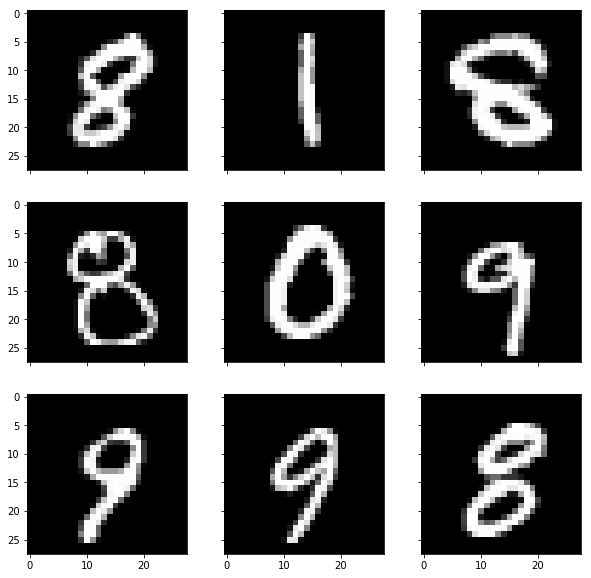

In [5]:
# show some examples from the MNIST training data set
fig = plt.figure(0, [10,10])
axes = fig.subplots(3, 3, sharex='col', sharey='row')
examples = np.random.choice(np.arange(x_train.shape[0]),size=9,replace=False) 
ii = 0
for row in axes:
    for col in row:
        col.imshow(x_train[examples[ii],:,:],cmap='gray')
        ii+=1
plt.show()

In [6]:
# do some preprocessing of the data

# some parameters
num_classes = 10 # number of distinct digits
img_x, img_y = 28, 28 # input image dimensions
input_shape = (img_x, img_y, 1) # shape of each image in collection

# some hyperparameters
batch_size = 128
epochs = 8

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel (last dimension) - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_validate = x_validate.reshape(x_validate.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)

# convert the data to the right type
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # normalize pixel values to between zero and one
x_validate /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validate = keras.utils.to_categorical(y_validate, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

('x_train shape:', (60000, 28, 28, 1))
('y_train shape:', (60000,))
(60000, 'train samples')
(5000, 'validation samples')
(5000, 'test samples')


In [7]:
# another hyperparameter
learning_rate = 0.001

# define the model
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = AccuracyHistory()

In [8]:
# train the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validate, y_validate),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)

Train on 60000 samples, validate on 5000 samples
Epoch 1/8
60000/60000 [==============================] - 2s 40us/step - loss: 0.2660 - acc: 0.9217 - val_loss: 0.0463 - val_acc: 0.9838
Epoch 2/8
60000/60000 [==============================] - 2s 25us/step - loss: 0.0718 - acc: 0.9786 - val_loss: 0.0355 - val_acc: 0.9900
Epoch 3/8
60000/60000 [==============================] - 2s 25us/step - loss: 0.0511 - acc: 0.9841 - val_loss: 0.0211 - val_acc: 0.9928
Epoch 4/8
60000/60000 [==============================] - 2s 25us/step - loss: 0.0389 - acc: 0.9880 - val_loss: 0.0219 - val_acc: 0.9932
Epoch 5/8
60000/60000 [==============================] - 2s 25us/step - loss: 0.0304 - acc: 0.9903 - val_loss: 0.0149 - val_acc: 0.9950
Epoch 6/8
60000/60000 [==============================] - 2s 25us/step - loss: 0.0247 - acc: 0.9921 - val_loss: 0.0197 - val_acc: 0.9928
Epoch 7/8
60000/60000 [==============================] - 2s 25us/step - loss: 0.0217 - acc: 0.9933 - val_loss: 0.0175 - val_acc: 0.9944

('Test loss:', 0.03749842343835626)
('Test accuracy:', 0.9878)


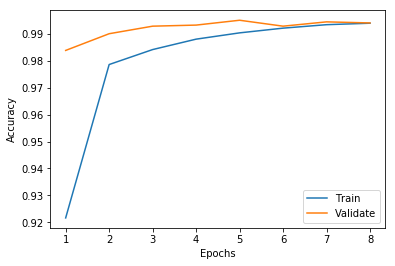

In [9]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1,epochs+1), history.acc, range(1,epochs+1), history.val_acc)
plt.legend(['Train','Validate'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [10]:
# use the trained model to predict classes of x_test
y_test_prime = model.predict(x_test)
print(y_test_prime)
y_test_prime_class = np.argmax(y_test_prime,axis=1)
print(y_test_prime_class)

[[1.5111784e-10 2.2067850e-10 9.7212793e-10 ... 9.9999976e-01
  8.7037494e-10 1.0215546e-08]
 [2.1139931e-07 1.0257148e-06 9.9999845e-01 ... 9.8056807e-10
  6.2199312e-08 1.6236547e-13]
 [8.2184897e-08 9.9996996e-01 1.6458217e-06 ... 1.5820644e-05
  7.2967146e-06 8.4085041e-09]
 ...
 [1.6602435e-06 2.2349562e-08 9.0110129e-01 ... 1.0497779e-10
  9.7771049e-02 5.5550550e-11]
 [1.4442293e-10 1.5092052e-08 1.7888504e-09 ... 1.3646671e-06
  8.8327306e-06 6.9886147e-07]
 [1.0000000e+00 5.7155981e-14 6.5820271e-10 ... 1.1533171e-09
  3.7704138e-11 4.4854034e-10]]
[7 2 1 ... 2 4 0]


[8 6 3 6]


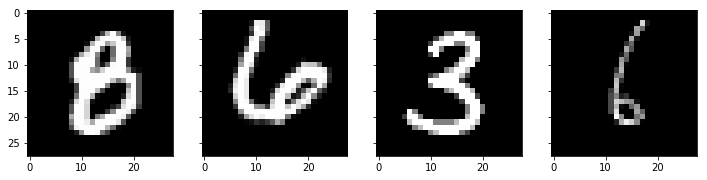

In [11]:
# show some specific predictions 
fig = plt.figure(0, [12, 3])
axes = fig.subplots(1, 4, sharex='col', sharey='row')
examples = np.random.choice(np.arange(x_test.shape[0]),size=4,replace=False)
print(y_test_prime_class[examples])
ii = 0
for col in axes:
    col.imshow(x_test[examples[ii],:,:].reshape(img_x,img_y),cmap='gray')
    ii+=1
plt.show()

Displaying activation map 0


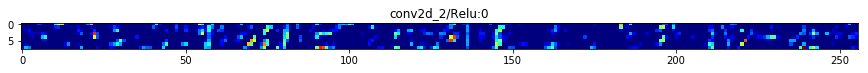

Displaying activation map 1


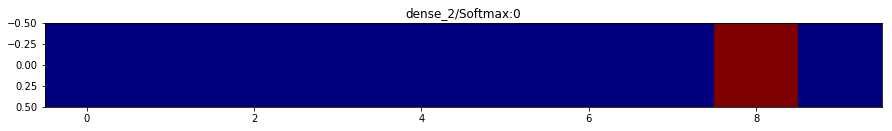

Displaying activation map 2


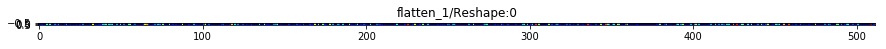

Displaying activation map 3


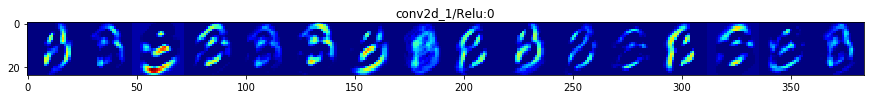

Displaying activation map 4


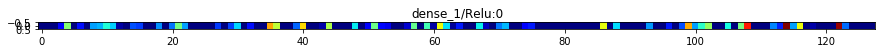

Displaying activation map 5


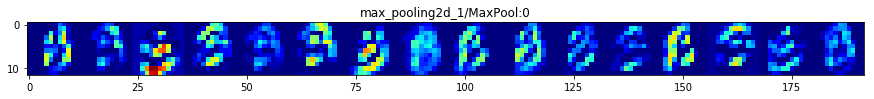

Displaying activation map 6


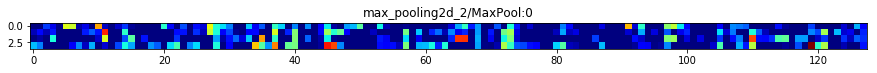

In [12]:
# look at the activations for the first prediction above
one_test = x_test[examples[0]].reshape(1,28,28,1)
activations = (get_activations(model, one_test))
display_activations(activations)